<a href="https://colab.research.google.com/github/jyotidabass/Tongue-classification/blob/main/Tongue_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMAGE LOADER

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


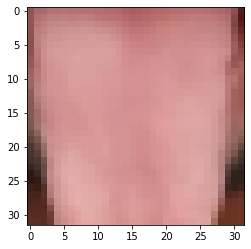

In [26]:
from multiprocessing import freeze_support

import torch
from torch import nn
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets
from torchvision.transforms import transforms
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
import PIL
from pathlib import Path

num_classes = 3
batch_size = 100
num_of_workers = 3

DATA_PATH_TRAIN = Path('/content/drive/MyDrive/Tongue/Train')
DATA_PATH_TEST = Path('/content/drive/MyDrive/Tongue/Test')

trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

train_dataset = datasets.ImageFolder(root=DATA_PATH_TRAIN, transform=trans)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_of_workers)

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
    plt.show()

def main():
    # get some random training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    # show images
    imshow(images)

if __name__ == "__main__":
    main()

#CNN MAIN

In [27]:
from multiprocessing import freeze_support

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets
from torchvision.transforms import transforms
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Hyperparameters.
num_epochs = 20
num_classes = 3
batch_size = 100
learning_rate = 0.001
num_of_workers = 3

DATA_PATH_TRAIN = Path('/content/drive/MyDrive/Tongue/Train')
DATA_PATH_TEST = Path('/content/drive/MyDrive/Tongue_256/Validation_256')
MODEL_STORE_PATH = Path('/content/drive/MyDrive')

trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

# Tongue dataset.
train_dataset = datasets.ImageFolder(root=DATA_PATH_TRAIN, transform=trans)
test_dataset = datasets.ImageFolder(root=DATA_PATH_TEST, transform=trans)

# Create custom random sampler class to iter over dataloader.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_of_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_of_workers)

# CNN we are going to implement.
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output


class CNNet(nn.Module):
    def __init__(self, num_class):
        super(CNNet, self).__init__()

        # Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3, out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)

        # Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 , self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128, out_features=num_class)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1, 128)
        output = self.fc(output)
        return output


# Check if gpu support is available
cuda_avail = torch.cuda.is_available()

# Create model, optimizer and loss function
model = CNNet(num_classes)

# if cuda is available, move the model to the GPU
if cuda_avail:
    model.cuda()

# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

def save_models(epoch):
    torch.save(model.state_dict(), f"{epoch}.model")
    print("Checkpoint saved")

def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)

        test_acc += torch.sum(prediction == labels.data).float()

    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 4242 * 100

    return test_acc


def train(num_epoch):
    best_acc = 0.0

    for epoch in range(num_epoch):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the test set
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            train_acc += torch.sum(prediction == labels.data).float()

        # Call the learning rate adjustment function
        #adjust_learning_rate(epoch)

        # Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 4242 * 100
        train_loss = train_loss / 8484

        # Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

        # Print the metrics
        print(f"Epoch {epoch + 1}, Train Accuracy: {train_acc} , TrainLoss: {train_loss} , Test Accuracy: {test_acc}")

if __name__ == '__main__':
    freeze_support()
    train(num_epochs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checkpoint saved
Epoch 1, Train Accuracy: 0.21216408908367157 , TrainLoss: 0.0038678189739584923 , Test Accuracy: 0.28288543224334717
Epoch 2, Train Accuracy: 0.40075433254241943 , TrainLoss: 0.003487707581371069 , Test Accuracy: 0.28288543224334717
Epoch 3, Train Accuracy: 0.6129184365272522 , TrainLoss: 0.003110694931820035 , Test Accuracy: 0.28288543224334717
Epoch 4, Train Accuracy: 0.6600660085678101 , TrainLoss: 0.0027461836580187082 , Test Accuracy: 0.28288543224334717
Epoch 5, Train Accuracy: 0.6364921927452087 , TrainLoss: 0.002544357208535075 , Test Accuracy: 0.28288543224334717
Epoch 6, Train Accuracy: 0.6836398243904114 , TrainLoss: 0.0022425628267228603 , Test Accuracy: 0.28288543224334717
Epoch 7, Train Accuracy: 0.6600660085678101 , TrainLoss: 0.002064561704173684 , Test Accuracy: 0.28288543224334717
Epoch 8, Train Accuracy: 0.6836398243904114 , TrainLoss: 0.001927018747664988 , Test Accuracy: 0.28288543224334717
Epoch 9, Train Accuracy: 0.6836398243904114 , TrainLoss: 0

#TEST WITH NEW IMAGE

In [28]:
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from PIL import Image
#from cnn_main import CNNet
from pathlib import Path

model = CNNet(3)
checkpoint = torch.load(Path('/content/10.model'))
model.load_state_dict(checkpoint)
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

model.eval()

image = Image.open(Path('/content/drive/MyDrive/Tongue_256/Train_256/Vata_256 resized/DB764DAA-F118-41EF-8AA0-79149C78E525 - Khushbu Pathak.jpeg'))
input_loader = DataLoader(dataset=image, batch_size=1, shuffle=False, num_workers=3)
input_loader = trans(image)
input_loader = input_loader.view(1, 3, 32,32)

output = model(input_loader)

prediction = output.data.numpy().argmax()
print(prediction)

if (prediction == 1):
    print ('Kapha')
if (prediction == 2):
    print ('Pitta')
if (prediction == 3):
    print ('Vata')

1
Kapha


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
